In [1]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
from ordered_set import OrderedSet
import time
from sqlitedict import SqliteDict

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option("display.max_rows", 100, "display.max_columns", None)
from tabulate import tabulate
from IPython.display import display

In [47]:
agent_to_path = {
                 'Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/database/',
                 'Original': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/database/', 
                 'FMSTS': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1484/database/',
                }

In [48]:
# load agent logs
episodes_logs_dict = {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    print(f'\nLoading logs for {display_name} agent from {path}...')
    start_t = time.time()
    episodes_logs_dict[display_name] = {}
    while True:
        try:
            with SqliteDict(path+'episodes_log.sqlite') as log:
                for key, val in log.items():
                    # read into memory
                    episodes_logs_dict[display_name][key] = val
                log.close()
            break
        except:
            # database locked since is being written to, wait and try again
            time.sleep(1)
    print(f'Loaded {display_name} agent episodes log in {time.time() - start_t:.3f} s')
    print(f'Loaded {display_name} agent epochs log in {time.time() - start_t:.3f} s')
print(f'\nAll agent logs loaded.')


Loading logs for Retro agent from /scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/database/...
Loaded Retro agent episodes log in 0.361 s
Loaded Retro agent epochs log in 0.361 s

Loading logs for Original agent from /scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/database/...
Loaded Original agent episodes log in 0.062 s
Loaded Original agent epochs log in 0.062 s

Loading logs for FMSTS agent from /scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1484/database/...
Loaded FMSTS agent episodes log in 0.013 s
Loaded FMSTS agent epochs log in 0.013 s

All agent logs loaded.


In [49]:
_df = defaultdict(list)
for agent, log in episodes_logs_dict.items():
    print(log.keys())
    
    # yvals
    _df['num_nodes'].extend(log['num_nodes'])
    _df['lp_iterations'].extend(log['lp_iterations'])
#     _df['reward'].extend(log['reward'])
    _df['R'].extend(log['R'])
    
    # xvals
    if 'num_episodes' not in log:
        print(f'num_episodes not found in agent {agent} log, estimating...')
        _df['num_episodes'].extend([ep for ep in range(log['episode_counter']+1)])
    else:
        _df['num_episodes'].extend(log['num_episodes'])
    if 'num_epochs' not in log:
        print(f'num_epochs not found in agent {agent} log, estimating...')
        mean_epochs_per_ep = int((log['epoch_counter']+1) / (log['episode_counter']+1))
        print([(ep+1)*mean_epochs_per_ep for ep in range(log['episode_counter']+1)])
        _df['num_epochs'].extend([(ep+1)*mean_epochs_per_ep for ep in range(log['episode_counter']+1)])
    else:
        _df['num_epochs'].extend(log['num_epochs'])
    if 'num_actor_steps' not in log:
        print(f'num_actor_steps not found in agent {agent} log, estimating...')
        total_steps = np.sum(log['num_steps'])
        mean_steps_per_ep = int(total_steps / (log['episode_counter']+1))
        _df['num_actor_steps'].extend([(ep+1)*mean_steps_per_ep for ep in range(log['episode_counter']+1)])
    else:
        _df['num_actor_steps'].extend(log['num_actor_steps'])
        
    # generate per-episode number of steps
    _df['num_episode_steps'].append(log['num_actor_steps'][0])
    for episode in range(1, len(log['num_actor_steps'])):
        episode_steps = log['num_actor_steps'][episode] - log['num_actor_steps'][episode-1]
        _df['num_episode_steps'].append(episode_steps)
    
    print(len(_df['num_nodes']))
    print(len(_df['num_episodes']))
    print(len(_df['num_epochs']))
    print(len(_df['num_actor_steps']))
    print(len(_df['num_episode_steps']))
    
#     print(_df['num_nodes'])
#     print(_df['num_epochs'])
    
    # labels
    _df['Agent'].extend([agent for _ in range(len(log['num_nodes']))])
    
df = pd.DataFrame(_df)
display(df[:10])
display(df)

dict_keys(['agent_name', 'agent_reward', 'agent_device', 'batch_size', 'lr', 'gamma', 'threshold_difficulty', 'learner_name', 'num_steps', 'extrinsic_R', 'R', 'episode_run_time', 'num_nodes', 'solving_time', 'lp_iterations', 'epsilon', 'per_beta', 'elapsed_training_time', 'num_epochs', 'num_episodes', 'num_actor_steps'])
146877
146877
146877
146877
146877
dict_keys(['agent_name', 'agent_reward', 'agent_device', 'batch_size', 'lr', 'gamma', 'threshold_difficulty', 'learner_name', 'num_steps', 'R', 'episode_run_time', 'num_nodes', 'solving_time', 'lp_iterations', 'epsilon', 'per_beta', 'elapsed_training_time', 'num_epochs', 'num_episodes', 'num_actor_steps'])
149697
149697
149697
149697
149697
dict_keys(['agent_name', 'agent_reward', 'agent_device', 'batch_size', 'lr', 'gamma', 'threshold_difficulty', 'learner_name', 'num_steps', 'extrinsic_R', 'R', 'episode_run_time', 'num_nodes', 'solving_time', 'lp_iterations', 'epsilon', 'per_beta', 'elapsed_training_time', 'num_epochs', 'num_episode

,num_nodes,lp_iterations,R,num_episodes,num_epochs,num_actor_steps,num_episode_steps,Agent
0,394.0,7934.0,-174,0,0,68877,68877,Retro
1,233.0,7137.0,-96,1,19,68993,116,Retro
2,144300.0,3840674.0,-62893,2,30,147194,78201,Retro
3,11065.0,308691.0,-3640,3,7475,152728,5534,Retro
4,54906.0,2101885.0,-17011,4,7993,180285,27557,Retro
5,159.0,9717.0,-47,5,10533,180364,79,Retro
6,63.0,4388.0,-20,6,10538,180395,31,Retro
7,1553.0,55800.0,-459,7,10540,181171,776,Retro
8,41.0,3008.0,-15,8,10595,181191,20,Retro
9,73.0,4712.0,-23,9,10596,181227,36,Retro


,num_nodes,lp_iterations,R,num_episodes,num_epochs,num_actor_steps,num_episode_steps,Agent
0,394.0,7934.0,-174,0,0,68877,68877,Retro
1,233.0,7137.0,-96,1,19,68993,116,Retro
2,144300.0,3840674.0,-62893,2,30,147194,78201,Retro
3,11065.0,308691.0,-3640,3,7475,152728,5534,Retro
4,54906.0,2101885.0,-17011,4,7993,180285,27557,Retro
...,...,...,...,...,...,...,...,...
153930,285.0,7526.0,-142,4233,211735,2210233,142,FMSTS
153931,27.0,2091.0,-13,4234,211749,2210246,13,FMSTS
153932,1013.0,20976.0,-506,4235,211750,2210752,506,FMSTS
153933,423.0,8549.0,-211,4236,211800,2210963,211,FMSTS


In [78]:
x = 'num_episode_steps'
ylabel = None

xaxis_label_style = 'sci' # paper training curve
# xaxis_label_style = 'plain'

# xlog = False
xlog = True

element = 'step' # bars step
fill = False # True alse
cumulative = True
stat = 'probability' # count probability density
common_norm = False # True False
multiple = 'layer'
title = None

# plot_legend = True
plot_legend = False 

xlim = None
xlim = [1e3, None] # inset

ylim = None
ylim = [0.93, 1.0] # inset

# scaling_factor = 0.6 # paper training curve
scaling_factor = 0.2 # inset
# width_scaling_factor = 1.5
width_scaling_factor = 1
height_scaling_factor = 1

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

In [79]:
if x == 'num_episode_steps':
    xlabel = 'B\&B Steps'

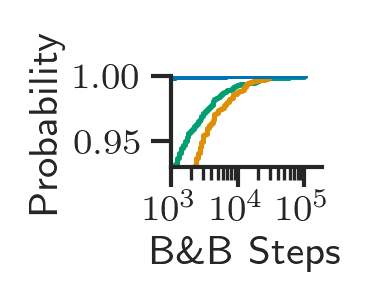

In [80]:
f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.histplot(data=df,
                 x=x,
                 hue='Agent',
#                  hue_order=list(agent_to_path.keys()),
                 element=element,
                 fill=fill,
                 cumulative=cumulative,
                 stat=stat,
                 common_norm=common_norm,
                 multiple=multiple,
                 log_scale=xlog,
                 legend=plot_legend,
                )
# if plot_legend:
#     plt.legend(loc='upper center', 
#                bbox_to_anchor=(0.5, 1.2), ncol=3, 
#                prop={'size': 5}, 
# #                labels=['Retro', 'Original', 'FMSTS'][::-1],
#               ) # WARNING: HACK to make labels same order as seaborn, check
if xlabel is not None:
    plt.xlabel(xlabel)
else:
    plt.xlabel(x)
if ylabel is not None:
    plt.ylabel(ylabel)
if title is not None:
    plt.title(title)
if xlim is not None:
    plt.xlim(left=xlim[0], right=xlim[1])
if ylim is not None:
    plt.ylim(bottom=ylim[0], top=ylim[1])
# plt.xticks()
# plt.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
# ax.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
plt.gcf().patch.set_alpha(0.0)
# plt.ylim(bottom=ylim[0], top=ylim[1])
